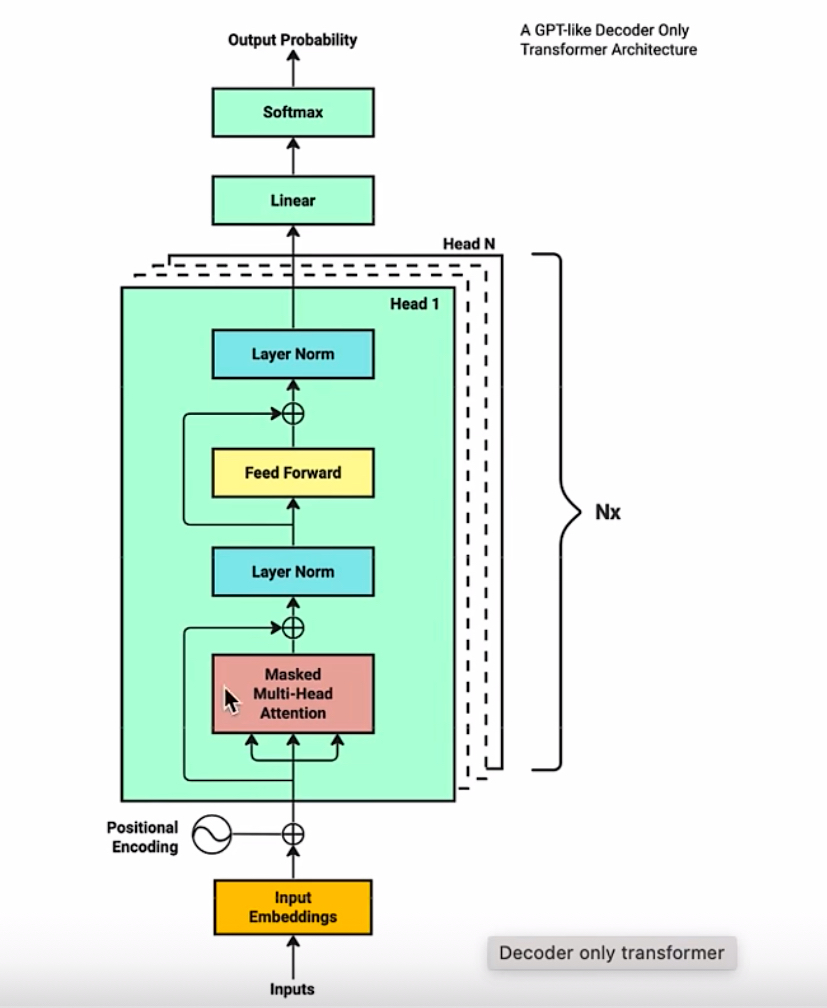

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import requests

# **首先，获取数据集**

In [ ]:
# Load training data
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text

'Chapter 1: Building Rapport and Capturing Attention\nSubpoint: Understanding the Importance of Building Rapport\nBuilding rapport is a fundamental skill in sales that cannot be underestimated. It lays the foundation for establishing a connection with your potential customers, gaining their trust, and ultimately convincing them to make a purchase. Rapport can be defined as a harmonious relationship based on mutual understanding and empathy. When you build rapport with someone, you create a sense of familiarity, comfort, and shared interests, making it easier to communicate and influence their decision-making process.\nOne of the main reasons why building rapport is crucial in sales is that people are more likely to buy from someone they like and trust. By establishing a positive and genuine connection with your customers, you increase their confidence in you and your product or service. People want to do business with individuals they feel comfortable with, those who understand their n

# **将数据集进行词嵌入何位置嵌入**
tokenized ：这里使用openai的tiktoken

In [ ]:
# 超参数
context_length = 16
d_model = 64
batch_size  = 4
num_heads = 4

In [ ]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

In [ ]:
tokenized_text = encoding.encode(text)
len(tokenized_text)
# 将数据变为张量
tokenized_text = torch.tensor(tokenized_text,dtype=torch.long)
max_token_value = tokenized_text.max().item()

将文字全部一一对应成为数字

模型训练的时候要截取一部分用于训练，小部分用于验证

In [ ]:
train_idex = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:train_idex]
val_data = tokenized_text[train_idex:]

x 是输入，y 是模型应该输出的正确答案。我们用 x 输入模型，计算输出再和 y 做对比，计算 loss（损失函数），从而训练模型。|

In [ ]:
# 训练准备
data = train_data
idxs = torch.randint(0, len(data) - context_length, (batch_size,))
x_batch = torch.stack([torch.tensor(data[i:i+context_length]) for i in idxs]) # 四个批次，每个批次16个token
y_batch = torch.stack([torch.tensor(data[i+1:i+context_length+1]) for i in idxs])
x_batch.shape

<ipython-input-7-6d2d43655c49>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.stack([torch.tensor(data[i:i+context_length]) for i in idxs]) # 四个批次，每个批次16个token
<ipython-input-7-6d2d43655c49>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.stack([torch.tensor(data[i+1:i+context_length+1]) for i in idxs])


torch.Size([4, 16])

In [ ]:
import pandas as pd
pd.DataFrame(x_batch[0].numpy())
encoding.decode(x_batch[0].numpy())

'ivate your audience and create an emotional connection. Make sure the story highlights the benefits'

加入维度，将一维的16个token加上64个维度

In [ ]:
input_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
x_batch_embedded = input_embedding_lookup_table(x_batch)
y_batch_embedded = input_embedding_lookup_table(y_batch)
# 4*16*64

加入位置信息

In [ ]:
import math
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1)

In [ ]:
x = x_batch_embedded + position_encoding_lookup_table
y = y_batch_embedded + position_encoding_lookup_table
pd.DataFrame(x[0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.688837,3.725847,-0.815356,-0.228059,0.364282,-0.073856,-0.063544,0.053472,0.733350,2.311485,...,0.448795,-0.377319,1.363587,1.298199,-0.409155,0.167508,-0.496627,1.482185,-0.828576,1.133600
1,1.555281,0.201995,1.201478,0.344589,-0.670140,1.517842,-0.817520,0.699606,1.778779,0.103426,...,-0.223793,1.988424,-0.045430,1.188734,-1.468092,0.548247,0.507753,2.013791,-0.804616,2.199130
2,1.697783,0.589960,1.068312,1.018384,0.119458,0.948629,0.642738,0.789954,-0.185434,1.888490,...,-0.494240,1.494025,-0.362905,0.036352,-0.679086,0.523067,-0.047744,-0.053475,-1.916929,0.806036
3,-2.049759,-1.126780,2.077218,-0.910649,0.831365,0.274016,-0.937351,0.962361,0.805547,0.131445,...,-0.681739,0.288346,0.839593,0.897940,-1.776006,0.984048,-1.150269,2.004587,1.294039,0.797431
4,-1.443262,0.416872,1.204301,0.371930,0.359549,-0.570664,3.368767,0.328248,0.503447,-0.693547,...,1.880912,0.028520,0.508650,0.682088,0.395389,2.076414,-1.556135,0.258397,-0.429559,0.917942
5,-3.436553,-0.303473,0.138006,-0.498019,1.099663,-1.938085,2.116102,-1.037207,0.708373,0.231476,...,-1.321589,0.748129,-1.433260,0.631051,0.533337,0.360557,0.259479,2.396457,-2.161693,2.227856
6,0.170245,-0.727873,0.171374,0.779648,0.017036,0.710915,2.278872,-2.521039,-0.260599,0.640331,...,0.819767,-0.505078,-1.945451,3.376018,1.359538,-0.041455,0.415643,2.085017,-0.010853,0.904054
7,0.951761,1.958984,-1.739927,-0.562245,0.757030,-2.079940,0.016343,1.008328,1.609304,-1.285978,...,1.373042,0.887061,0.229711,-0.160766,0.924486,0.397112,-1.041323,0.414230,-0.260685,2.787375
8,1.389253,1.665269,-1.782368,2.414368,-0.009417,0.686085,0.797324,0.008896,1.362574,1.575271,...,0.034199,0.351156,-0.949407,0.602993,0.355705,3.855633,-0.140866,-0.270222,-0.153138,0.204768
9,-0.648406,-1.607006,0.734525,0.279453,0.007650,1.820063,0.348033,0.132090,-1.452645,-0.484838,...,-0.476182,-0.348065,0.144573,1.136048,1.269284,-0.033899,-1.522431,-0.296594,0.087978,1.367257


# **多头注意力机制**

In [ ]:
# 获取qkv
wq = nn.Linear(d_model, d_model)
wk = nn.Linear(d_model, d_model)
wv = nn.Linear(d_model, d_model)
Q = wq(x)
K = wk(x)
V = wv(x)
Q.shape

torch.Size([4, 16, 64])

In [ ]:
# 将Q,K,V切割成几份，分别对应多个头进行处理
Q = Q.reshape(batch_size, context_length, num_heads, d_model//num_heads).permute(0, 2, 1, 3)
K = K.reshape(batch_size, context_length, num_heads, d_model//num_heads).permute(0, 2, 1, 3)
V = V.reshape(batch_size, context_length, num_heads, d_model//num_heads).permute(0, 2, 1, 3)
V.shape

torch.Size([4, 4, 16, 16])

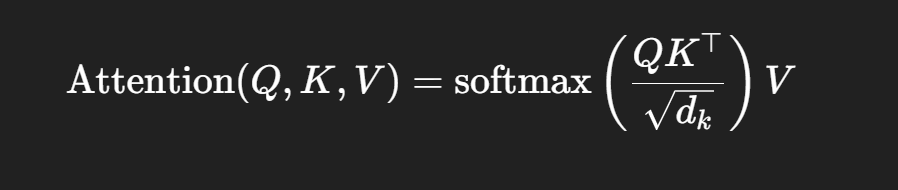

In [ ]:
output = Q @ K.transpose(-2,-1) / math.sqrt(d_model//num_heads)
output.shape


torch.Size([4, 4, 16, 16])

In [ ]:
mask = torch.triu(torch.ones(context_length,context_length),diagonal=1).bool() # 将16*16（context_len,new_d_model）加上mask
output = output.masked_fill(mask,float('-inf'))
pd.DataFrame(output[0,0].detach().numpy()) # 第一个批次第一个头处理的结果

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.334024,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.221280,-0.363058,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,0.063968,0.639408,-0.059911,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,-0.245244,-0.150378,-0.470843,0.044533,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.585026,0.004773,-0.780354,0.033143,-0.057055,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.293504,-0.627069,-1.009375,-0.493693,-0.907418,0.021604,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.720371,-0.297127,-0.210064,-0.468615,-0.111464,0.820930,0.369040,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-0.312400,0.097689,-0.898148,0.666830,0.087585,0.393350,-0.217328,0.206177,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.173142,-0.272753,-0.281720,-0.076349,0.212472,0.695027,0.494768,0.224384,0.030521,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.603216,-0.358651,-1.593405,-0.137414,-0.320237,-0.232174,0.039621,-0.145136,-0.261476,0.205471,-inf,-inf,-inf,-inf,-inf,-inf


In [ ]:
# 进行softmax
attention_score = F.softmax(output,dim=-1) #对最后一个维度
pd.DataFrame(attention_score[0,0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.535385,0.464615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.273120,0.485583,0.241298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.236201,0.259706,0.188498,0.315595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.342806,0.191888,0.087513,0.197410,0.180383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.313676,0.124934,0.085241,0.142760,0.094390,0.238999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.232277,0.083968,0.091606,0.070735,0.101099,0.256850,0.163465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.083177,0.125343,0.046304,0.221450,0.124083,0.168463,0.091473,0.139707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.110152,0.070525,0.069896,0.085830,0.114571,0.185629,0.151941,0.115944,0.095511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.070654,0.090230,0.026248,0.112573,0.093764,0.102395,0.134375,0.111707,0.099438,0.158616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# 与V相乘
A = attention_score @ V
pd.DataFrame(A[0,0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.208069,0.449104,-0.322977,-0.442142,-0.008770,0.369528,0.020233,-0.279361,0.349904,-0.209314,0.133461,0.028362,0.101420,0.498952,-0.474304,0.258777
1,0.218814,0.260588,-0.412024,-0.308689,-0.062306,0.088547,-0.022048,-0.138146,0.215291,-0.101146,0.065602,-0.006664,0.087236,0.460840,-0.340107,0.238975
2,0.249433,0.242607,-0.354857,-0.328346,0.022883,0.121475,-0.077621,-0.131820,0.255016,-0.098626,0.083985,-0.006306,0.129056,0.395594,-0.331752,0.234586
3,0.278900,0.159179,-0.332382,-0.319963,0.042043,0.064013,-0.090742,-0.081390,0.251607,-0.078540,0.049875,-0.020221,0.157060,0.330604,-0.331430,0.198628
4,0.268101,0.184639,-0.357908,-0.304693,0.030547,0.065077,-0.103392,-0.099432,0.244121,-0.074126,0.074608,-0.024605,0.136907,0.364451,-0.308706,0.211354
5,0.263618,0.168341,-0.394497,-0.241930,0.004322,-0.001435,-0.115325,-0.082082,0.209262,-0.053227,0.063462,-0.015728,0.112866,0.407717,-0.301099,0.218648
6,0.273892,0.187180,-0.365048,-0.262532,0.022911,0.024862,-0.118403,-0.090250,0.231899,-0.045868,0.084755,-0.035399,0.109580,0.399763,-0.320940,0.217548
7,0.259166,0.175698,-0.399622,-0.219830,-0.032494,-0.046699,-0.093285,-0.080637,0.187963,-0.018356,0.070737,-0.036918,0.080470,0.429770,-0.296906,0.211696
8,0.266158,0.183444,-0.377714,-0.239072,-0.009125,-0.005125,-0.103790,-0.091088,0.210647,-0.042982,0.064242,-0.021917,0.106040,0.403340,-0.324318,0.206887
9,0.270067,0.182556,-0.401058,-0.217641,-0.047576,-0.041928,-0.077510,-0.078148,0.183478,-0.036362,0.040327,-0.025750,0.105359,0.417446,-0.329347,0.185372


In [ ]:
# 将所有的头合并回来
A = A.transpose(1,2).reshape(batch_size,-1,d_model)
A.shape

torch.Size([4, 16, 64])

In [ ]:
# 最后要再做一次线性变化
wo = nn.Linear(d_model,d_model)
output = wo(A)
# output.shape
# 最后再进行一次残差连接，防止梯度消失
output = output  + x
output.shape

torch.Size([4, 16, 64])

# **层归一化**

In [ ]:
layer_norm = nn.LayerNorm(d_model)
layer_norm_output = layer_norm(output)
layer_norm_output.shape

torch.Size([4, 16, 64])

# **前馈网络**

神经网络，学习就是在这里进行学习

需要先将维度拓宽4倍，进行激活，看那些权值高

最后在缩小会原来维度

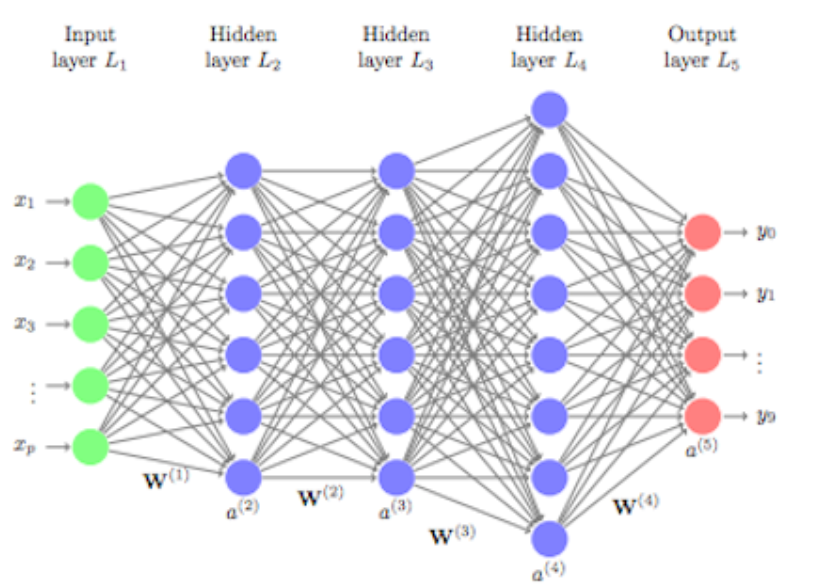

In [ ]:
output = nn.Linear(d_model,d_model*4)(layer_norm_output)
output = nn.ReLU()(output)
output = nn.Linear(d_model*4,d_model)(output)
output.shape

torch.Size([4, 16, 64])

In [ ]:
# 再进行残差链接
output = output + layer_norm_output
output.shape

torch.Size([4, 16, 64])

In [ ]:
# 再进行一次layernorm
output = layer_norm(output)
output.shape

torch.Size([4, 16, 64])

这样，我们一个transformer block就完成了

# **接下来，需要和整个词汇表做一次线性变化，才能在整个所有的token中明确context_length个token对应每一个token的概率**


这里，会取出概率最高的token，再返回给模型进行验证，训练。。。

In [ ]:
# 先建立一个final_linear_layer
final_linear_layer = nn.Linear(d_model,max_token_value+1)
output = final_linear_layer(output)
output.shape

torch.Size([4, 16, 100070])

# **最后做一个softmax，将每一行的总和加起来为1，转换为概率值**

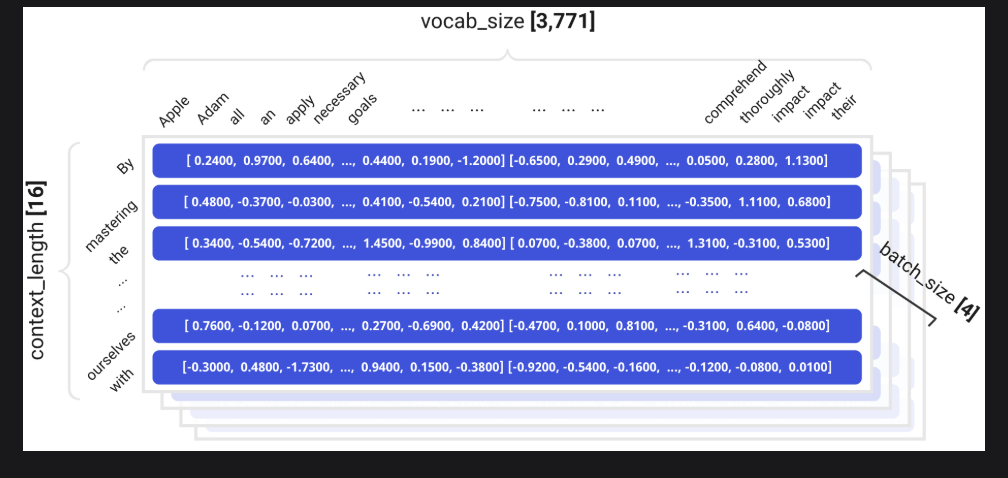

In [ ]:
final_output = F.softmax(output,dim=-1)
predicted_idx = torch.argmax(final_output[0,0],dim=-1).item()
encoding.decode([predicted_idx])

'azor'

In [ ]:
!python /content/t.py

hello world


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# 设置超参数
batch_size = 4
d_model = 512
context_length = 16
num_heads = 8
head_dim = d_model // num_heads  # 每个头对应的维度是64维--》16*64
num_blocks = 12
drop_out = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"


# 开始transformer模型构造
# 前馈网络
class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fnn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(drop_out)
        )

    def forward(self, x):
        x = self.fnn(x)
        return x


# 单头注意力机制
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.Wq = nn.Linear(d_model, head_dim, bias=False)
        self.Wk = nn.Linear(d_model, head_dim, bias=False)
        self.Wv = nn.Linear(d_model, head_dim, bias=False)
        # 动态的mask
        self.register_buffer('mask', torch.tril(torch.ones(context_length, context_length)))
        self.Dropout = nn.Dropout(drop_out)

    def forward(self, x):  # x_size[batch_size, context_length, head_dim]其中context_length是变化的
        B, T, D = x.shape
        q = self.Wq(x)  # [4,16,512//8]
        k = self.Wk(x)
        v = self.Wv(x)
        output = q @ k.transpose(-2, -1) / math.sqrt(head_dim)
        # 这里q*k转置之后是16*16的矩阵，为一个正方形，而我们需要将上三角的词全部遮掩起来
        output = output.masked_fill_(self.mask[:T, :T] == 0, float('-inf'))
        output = F.softmax(output, dim=-1)
        output = self.Dropout(output)
        output = output @ v
        return output


# 多头
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList([Attention() for _ in range(num_heads)])  # 循环生成8个头
        self.Wo = nn.Linear(d_model, d_model)
        self.Dropout = nn.Dropout(drop_out)

    def forward(self, x):
        output = [head(x) for head in self.heads]  # 调用方法循环生成8个头
        output = torch.cat(output, dim=-1)  # 对其做拼接
        output = self.Dropout(self.Wo(output))
        return output


# 一个transformer块
class TransformerBlock(nn.Module):
    def __init__(self):
        super(TransformerBlock, self).__init__()
        # 定义两层归一化
        self.layer1 = nn.LayerNorm(d_model)
        self.layer2 = nn.LayerNorm(d_model)
        self.multi_attention = MultiHeadAttention()
        self.ffn = FeedForward()

    def forward(self, x):
        x = x + self.multi_attention(self.layer1(x))
        x = x + self.ffn(self.layer2(x))
        return x


# model
class Model(nn.Module):
    def __init__(self, max_token_value=1000256):
        super(Model, self).__init__()
        # 和最大的词汇表作映射
        self.vocab_linear = nn.Linear(d_model, max_token_value)
        self.token_lookup = nn.Embedding(max_token_value, d_model)
        # 把“词”或“字符”的编号（token id）转换成稠密的向量表示（embedding），这样模型才能理解和处理。
        self.transformer_blocks = nn.Sequential(
            *([TransformerBlock() for _ in range(num_blocks)] + [nn.LayerNorm(d_model)])
        )

    def forward(self, x_batch, y_batch=None):
        # 因为模型每次处理一个token，因此context_len是变化的
        # B, T, D = x_batch.shape
        position_embedding_lookup = torch.zeros(context_length, d_model, device=device)
        position = torch.arange(0, context_length, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(-math.log(10000.0) * torch.arange(0, d_model, 2, device=device).float() / d_model)
        position_embedding_lookup[:, 0::2] = torch.sin(position * div_term)
        position_embedding_lookup[:, 1::2] = torch.cos(position * div_term)
        output = self.token_lookup(x_batch) + position_embedding_lookup

        output = self.transformer_blocks(output)
        logits = self.vocab_linear(output)
        if y_batch is not None:
            B, T, V = logits.shape  # vocab_size = V

            logits_reshaped = logits.view(B * T, V)
            y_batch_reshaped = y_batch.view(B * T)  # 正确 reshape 真实标签

            loss = F.cross_entropy(input=logits_reshaped, target=y_batch_reshaped)
        else:
            loss = None

        return logits, loss

    # 定义一个方法，用于推理的时候，传入一段context_len的话，然后不断生成下一个token,直到100个
    def generate(self, x_batch, max_new_tokens=100, temperature=1.0):
        for _ in range(max_new_tokens):
            #  x_batch[batch_size=1,context_len]这个时候是传进来的x_batch没有进行tokenize，纯文字
            x_crop = x_batch[:, -context_length:]
            logits, _ = self.forward(x_crop)  # [batch_size,context_len,max_token_value]\
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            x_batch = torch.cat((x_batch, next_token), dim=1)

        return x_batch


In [ ]:
import os
import sys
import torch
import pickle
from contextlib import nullcontext
import tiktoken
# from model import Model

# 设置超参数
batch_size = 4
context_length = 16
max_epochs = 600
learning_rate = 0.001
eval_interval = 20
eval_iters = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

tokenizer = tiktoken.get_encoding('cl100k_base')
tokenized_text = tokenizer.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device)
p_size = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:p_size]
valid_data = tokenized_text[p_size:]

model = Model().to(device)


def get_batch(split):
    if split == 'train':
        data = train_data
    else:
        data = valid_data
    idxs = torch.randint(low=0, high=len(data) - context_length, size=[batch_size])
    x = torch.stack([data[i:i + context_length].clone().detach() for i in idxs])
    y = torch.stack([data[i + 1:i + context_length + 1].clone().detach() for i in idxs])

    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'valid']:
        losses = torch.zeros(eval_iters).to(device)
        for k in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out  # 计算平均loss output:{'train':1.23,'valid':1.23}


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
for step in range(max_epochs):
    if step % eval_interval == 0 or step == max_epochs - 1:
        losses = estimate_loss()
        print('Step', step, 'Training Loss', round(losses['train'].item(),3), 'Valid Loss', round(losses['valid'].item(),3))

    x, y = get_batch('train')
    _, loss = model(x, y)  # 每次循环就会调用forward方法，预测下一个词，并进行和y的比较验证，计算loss
    optimizer.zero_grad(set_to_none=True)  # 梯度清零
    loss.backward()
    optimizer.step()

torch.save(model.state_dict(), 'model.ckpt')


Step 0 Training Loss 13.977 Valid Loss 13.966
Step 20 Training Loss 8.76 Valid Loss 8.719
Step 40 Training Loss 7.785 Valid Loss 8.286
Step 60 Training Loss 6.843 Valid Loss 8.088
Step 80 Training Loss 7.116 Valid Loss 7.411
Step 100 Training Loss 7.008 Valid Loss 7.208
Step 120 Training Loss 6.459 Valid Loss 7.366
Step 140 Training Loss 6.41 Valid Loss 7.212
Step 160 Training Loss 6.674 Valid Loss 7.191
Step 180 Training Loss 6.173 Valid Loss 6.89
Step 200 Training Loss 6.305 Valid Loss 6.408
Step 220 Training Loss 6.295 Valid Loss 7.122
Step 240 Training Loss 5.818 Valid Loss 6.119
Step 260 Training Loss 5.93 Valid Loss 6.98
Step 280 Training Loss 5.732 Valid Loss 6.732
Step 300 Training Loss 5.48 Valid Loss 6.187
Step 320 Training Loss 5.633 Valid Loss 6.755
Step 340 Training Loss 5.464 Valid Loss 5.556
Step 360 Training Loss 4.905 Valid Loss 6.534
Step 380 Training Loss 5.475 Valid Loss 6.64
Step 400 Training Loss 5.428 Valid Loss 6.939
Step 420 Training Loss 5.276 Valid Loss 6.114

In [1]:
import os
import requests
import math
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The size of our model token embeddings
num_blocks = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention
learning_rate = 1e-3  # 0.001
dropout = 0.1  # Dropout rate
max_iters = 1000  # Total of training iterations <- Change this to smaller number for testing
eval_interval = 50  # How often to evaluate
eval_iters = 20  # Number of iterations to average for evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if it's available.
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

# Load training data
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Using TikToken (Same as GPT3) to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
max_token_value = max(tokenized_text) + 1  # the maximum value of the tokenized numbers
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device)  # put tokenized text into tensor

# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]


# Define Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.dropout = dropout
        # 实现具体ffn
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.d_model, out_features=4 * self.d_model),
            nn.ReLU(),
            nn.Linear(in_features=4 * self.d_model, out_features=self.d_model),
            nn.Dropout(self.dropout)  # 随机失活部分神经元，防止过拟合
        )

    def forward(self, x):
        return self.ffn(x)


# Define Scaled Dot Product Attention
class Attention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones((self.context_length, self.context_length))))  # Lower triangular mask
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Time steps(current context_length), Channels(dimensions)
        assert T <= self.context_length
        assert C == self.d_model
        q = self.query_layer(x)
        k = self.key_layer(x)
        v = self.value_layer(x)

        # Scaled dot product attention: Q @ K^T / sqrt(d_k)
        weights = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # Apply masked attention
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(input=weights, dim=-1)
        weights = self.dropout_layer(weights)

        # Apply dot product attention: weights @ V
        out = weights @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.d_model = d_model
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([Attention(head_size=self.head_size) for _ in range(self.num_heads)])
        self.projection_layer = nn.Linear(in_features=self.d_model, out_features=self.d_model)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out)
        return out


class TransformerBlock(nn.Module):

    def __init__(self, num_heads: int):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.head_size = d_model // num_heads  # head size should be divisible by d_model
        self.num_heads = num_heads
        self.dropout = dropout

        self.multi_head_attention_layer = MultiHeadAttention(head_size=self.head_size)
        self.feed_forward_layer = FeedForward()
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.d_model)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.d_model)

    def forward(self, x):
        # Note: The order of the operations is different from the original Transformer paper
        # The order here is: LayerNorm -> Multi-head attention -> LayerNorm -> Feed forward
        x = x + self.multi_head_attention_layer(self.layer_norm_1(x))  # Residual connection
        x = x + self.feed_forward_layer(self.layer_norm_2(x))  # Residual connection
        return x


class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.dropout = dropout
        self.max_token_value = max_token_value
        # Set up token embedding look-up table
        self.token_embedding_lookup_table = nn.Embedding(num_embeddings=self.max_token_value + 1,
                                                         embedding_dim=self.d_model)

        # Run all the transformer blocks
        # Different from original paper, here we add a final layer norm after all the blocks
        self.transformer_blocks = nn.Sequential(*(
                [TransformerBlock(num_heads=self.num_heads) for _ in range(self.num_blocks)] +
                [nn.LayerNorm(self.d_model)]
        ))
        self.language_model_out_linear_layer = nn.Linear(in_features=self.d_model, out_features=self.max_token_value)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        """
        # Set up position embedding look-up table
        # following the same approach as the original Transformer paper (Sine and Cosine functions)
        """
        position_encoding_lookup_table = torch.zeros(self.context_length, self.d_model)
        position = torch.arange(0, self.context_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
        position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
        position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
        # change position_encoding_lookup_table from (context_length, d_model) to (T, d_model)
        position_embedding = position_encoding_lookup_table[:T, :].to(device)
        x = self.token_embedding_lookup_table(idx) + position_embedding
        x = self.transformer_blocks(x)
        # The "logits" are the output values of our model before applying softmax
        logits = self.language_model_out_linear_layer(x)

        if targets is not None:
            B, T, C = logits.shape
            logits_reshaped = logits.view(B * T, C)
            targets_reshaped = targets.view(B * T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss = None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:, -self.context_length:]
            # Get predictions
            logits, loss = self(idx_crop)
            # Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:, -1, :]
            # Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1)
            # Sample from the probabilities' distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1)
            # Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# Initialize the model
model = TransformerLanguageModel()
model = model.to(device)


# Get input embedding batch
def get_batch(split: str):
    data = train_data if split == 'train' else val_data
    idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx + context_length] for idx in idxs]).to(device)
    y = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs]).to(device)
    return x, y


# Calculate loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# Use AdamW optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters - 1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:', step, 'Training Loss:', round(losses['train'].item(), 3), 'Validation Loss:',
              round(losses['valid'].item(), 3))

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Save the model state dictionary
torch.save(model.state_dict(), 'model-ckpt.pt')

# Generate
model.eval()
start = 'The salesperson'
start_ids = encoding.encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
y = model.generate(x, max_new_tokens=100)
print('---------------')
print(encoding.decode(y[0].tolist()))
print('---------------')


Step: 0 Training Loss: 11.663 Validation Loss: 11.716
Step: 20 Training Loss: 10.297 Validation Loss: 10.478
Step: 40 Training Loss: 8.867 Validation Loss: 9.022
Step: 60 Training Loss: 7.346 Validation Loss: 7.613
Step: 80 Training Loss: 6.878 Validation Loss: 7.297
Step: 100 Training Loss: 6.659 Validation Loss: 7.208
Step: 120 Training Loss: 6.544 Validation Loss: 7.104
Step: 140 Training Loss: 6.325 Validation Loss: 7.199
Step: 160 Training Loss: 6.34 Validation Loss: 6.685
Step: 180 Training Loss: 6.154 Validation Loss: 6.89
Step: 200 Training Loss: 6.203 Validation Loss: 6.673
Step: 220 Training Loss: 6.047 Validation Loss: 6.763
Step: 240 Training Loss: 5.872 Validation Loss: 6.497
Step: 260 Training Loss: 5.957 Validation Loss: 6.347
Step: 280 Training Loss: 5.679 Validation Loss: 6.391
Step: 300 Training Loss: 5.814 Validation Loss: 6.603
Step: 320 Training Loss: 5.414 Validation Loss: 6.496
Step: 340 Training Loss: 5.321 Validation Loss: 6.101
Step: 360 Training Loss: 5.206 V